In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_', string])
    plt.show()

In [3]:
DATA_IN_PATH = 'data-in/'
DATA_OUT_PATH = 'data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIG = 'nsmc_data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIG, 'r'))

In [6]:
print(train_input.shape)

(150000, 8)


In [7]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1] # 8을 집어넣은 것
kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension': 1} # 파라미터 정의

In [8]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'] + 1,
                                          output_dim = kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(kargs['num_filters'], kernel_size = kernel_size,
                                        padding = 'valid', activation = 'relu', # 값이 안날라가기 위해 padding 값을 valid로 준다
                                        kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3.)) #가중치 값이 넘치지 않게 제약조건을 걸어준다.
                          for kernel_size in [3, 4, 5]]
        self.pooling = layers.GlobalMaxPooling1D() # 풀사이즈가 있는 것이 아니고 전체에서 최대값을 뽑아내는 것이다.
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(kargs['hidden_dimension'], activation = 'relu',
                                kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(kargs['output_dimension'], activation = 'sigmoid',
                                kernel_constraint = tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis = -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [9]:
model = CNNClassifier(**kargs)
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [10]:
earlystop = EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0001, patience = 3)
checkpoint_path = DATA_OUT_PATH +model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint = ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy', verbose = 1, save_best_only = True, save_weights_only = True)

In [11]:
history = model.fit(train_input, train_label, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, 
                    validation_split = VALID_SPLIT, callbacks = [earlystop, checkpoint])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4584 - accuracy: 0.7749
Epoch 00001: val_accuracy improved from -inf to 0.82027, saving model to data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 21s 79ms/step - loss: 0.4584 - accuracy: 0.7749 - val_loss: 0.3952 - val_accuracy: 0.8203
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3529 - accuracy: 0.8451
Epoch 00002: val_accuracy improved from 0.82027 to 0.82580, saving model to data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 20s 76ms/step - loss: 0.3529 - accuracy: 0.8451 - val_loss: 0.3872 - val_accuracy: 0.8258
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.8729
Epoch 00003: val_accuracy did not improve from 0.82580
264/264 [==============================] - 20s 76ms/step - loss: 0.3016 - accuracy: 0.8729 - val_loss: 0.3975 - val_accuracy: 0.8223
Epoch 4/10
264/264 [=============

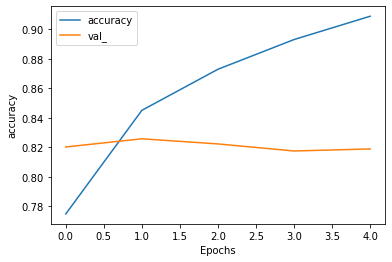

In [12]:
plot_graphs(history, 'accuracy')

In [13]:
DATA_OUT_PATH = 'data-out/'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [14]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

model.evaluate(test_input, test_label)

1563/1563 [==============================] - 2s 1ms/step - loss: 0.3876 - accuracy: 0.8263


[0.3875744938850403, 0.8263199925422668]